## <center>DataLab Cup 1: Text Feature Engineering</center>

<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2023</center>

### Overview

In this competition, you are provided with a supervised dataset $X$ consisting of the **raw content** of news articles and the **binary popularity **(where $1$ means "popular" and $−1$
means "unpopular", calculated based on the number of shares in online social networking services) of these articles as labels. Your goal is to learn a function $f$ from $X$ that is able to predict the popularity of an unseen news article.

### Dataset Format

- `train.csv` contains 27643 data points (news articles) with the attributes `Id`, `Page content`, and binary labels `Popularity`
- `test.csv` contains 11847 data points with the attributes `Id` and `Page content`


### Platform: [Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity)

## Feature Engineering is More Important Than You Expected


So far, we learn various machine learning techniques based on datasets where the date features are predefined. In many real-world applications, including this competition, we only get raw data and have to define the features ourself. **Feature engineering** is the process of using domain knowledge to create features that make machine learning algorithms work. While good modeling and training techniques help you make better predictions, feature engineering usually determines whether your task is "learnable".

To demonstrate the importance of feature engineering, let's use the [IMDB review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) to show how to extract meaningful information from a subset of these movie reviews to build a machine learning model that can predict whether a certain reviewer liked or disliked a movie.

You can download the [data](https://drive.google.com/open?id=1kxMaKHLe7hwx96cQavlSrxfgta6F7GgY) you will use below.

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
%matplotlib inline

In [19]:
import pandas as pd

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

                                              review  sentiment
0  I know that Chill Wills usually played lovable...          1
1  The arrival of an world famous conductor sets ...          1
2  This documentary is such a wonderful example o...          1
3  I really tried to like this movie but in the e...          0
4  Not one of Monogram's better(not trying to be ...          0


We get movie reviews in its raw content---there is only one feature called `review`. If the review is positive comment, then the label field `sentiment` equals to 1; otherwise 0. To be able to predict from text, we have to go through several preprocessing steps first.


### Preprocessing: Data Cleaning

Data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate pieces of information in the dataset. Let's print a review and see if we need to clean up the raw text:

In [20]:
print(df.loc[0,'review'])

I know that Chill Wills usually played lovable old sorts in Westerns. But his role in this segment is something I've remembered for a long time. Wills could be a first rate villain. Yes, Burgess Meredith's Fall was correct! That look in Hepplewhite's eye! It expressed porcine greed, ignorance, and the threat of violence all at once. Quite a performance, I think.<br /><br />The segment itself was a good one, too. Question: couldn't the little black bag cure alcoholism? I guess it did, sort of, with Fall. But the doctor would have been wise to apply the cure, if he had it, as quickly as possible to Hepplewhite.<br /><br />There is one moment that was annoying but also necessary. And it is something that appears to recur in these Night Gallery segments. It's Serling's constant need to sermonize. For that's what we got, one more time, with Dr. Fall. I don't know what was more frustrating, losing the black bag and all its miracles or not being to stop Fall from preaching about the bag's ben

As we can see here, the text contains HTML markup as well as punctuation and other non-letter characters. Since we care only about the semantics, we remove the HTML markup as it does not contain much useful semantics. Also, although punctuation marks might be useful in certain NLP contexts, we remove all punctuation marks for simplicity. One exception is the emoticon characters such as ":)" since they are certainly useful for sentiment analysis. Furthermore, we convert all text to lowercase since it doesn't matter if reviews are in upper or lower case.

In summary, we clean up the text by:

- removing all HTML tags
- removing punctuation marks but emoticons
- converting all characters to lowercase

To accomplish this task, we use Python's [regular expression](https://docs.python.org/3/library/re.html) (`re`) library, and a powerful HTML parsing tool [BeautifulSoup4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/). If you don't have BeautifulSoup4 yet, you can install it via Anaconda:

    > conda install beautifulsoup4

In [21]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

By calling `BeautifulSoup(text, 'html.parser')`, we constructs a BeautifulSoup object, which represents the document as a nested data structure, and you can navigate the tree easily, like selecting a tag or querying tags with some regex pattern (see more on [BeautifulSoup website](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#navigating-the-tree)). For this example, we simply remove all HTML tags (including the tag properties) and keep only the raw texts between tags by calling the method `get_text()`. After we remove the HTML markup, we used a slightly more complex regex to find emoticons, which we temporarily stored as emoticons. Next we remove all non-word characters from the text via the regex "[\W]+", convert the text into lowercase characters, and add the temporarily stored emoticons to the end of the text. Additionally, we removed the nose character (-) from the emoticons for consistency.

Let's do a sanity check:

In [22]:
print(preprocessor(df.loc[0,'review']))

i know that chill wills usually played lovable old sorts in westerns but his role in this segment is something i ve remembered for a long time wills could be a first rate villain yes burgess meredith s fall was correct that look in hepplewhite s eye it expressed porcine greed ignorance and the threat of violence all at once quite a performance i think the segment itself was a good one too question couldn t the little black bag cure alcoholism i guess it did sort of with fall but the doctor would have been wise to apply the cure if he had it as quickly as possible to hepplewhite there is one moment that was annoying but also necessary and it is something that appears to recur in these night gallery segments it s serling s constant need to sermonize for that s what we got one more time with dr fall i don t know what was more frustrating losing the black bag and all its miracles or not being to stop fall from preaching about the bag s benefit for humanity all while rubbing hepplewhite s g

Our cleaning preprocessor seems to work correctly. That's great!

Now, we need to think about how to split the text corpora into individual elements. This is called `tokenization`. One way to tokenize documents is to split them into individual words by splitting the cleaned document at its whitespace characters.

In [23]:
def tokenizer(text):
    return re.split('\s+', text.strip())

print(tokenizer('runners like running and thus they run'))

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']


The example sentence is now split into tokens. However, we see a problem here: the token "running" and "run" only differs in verb tense. It is not a good idea to keep them as different tokens as this introduces unnecessary redundancy in the vector representation. Let's merge them using a technique called `word stemming`.

### Preprocessing: Word Stemming

`Word stemming` is a process that transforms words into their root forms and allows us to map related words to the same stem. The original stemming algorithm was developed by Martin F. Porter in 1979 and is hence known as the P`orter stemming` algorithm. The [Natural Language Toolkit for Python](http://www.nltk.org/) implements the Porter stemming algorithm, which we use here. In order to install the NLTK, you can simply execute:

    > conda install nltk

NOTE: NLTK module provides powerful tools for various NLP tasks, such as the sentiment polarity scoring, common stop words, POS tagging, etc., which you may find useful for this competition.

In [24]:
from nltk.stem.porter import PorterStemmer

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

print(tokenizer_stem('runners like running and thus they run'))

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']


As we can see, the word "running" is now reduced to its root form "run".

NOTE: words stemming just heuristically strips outs prefix or suffix of words. Therefore, it'll produce strange result for some words, ex: the word "boring" will be wrongly reduced into non-existing word "bor". To overcome this, there's another technique, called **lemmatization**, which **grammatically** transforms words back to root form. Lemmatization is also implemented by NLTK in [nltk.stem](http://www.nltk.org/api/nltk.stem.html). Empirically, there is no much difference in performance between the two techniques.

### Preprocessing: Stop-Word Removal

`Stop-words` are simply words that are extremely common in all sorts of texts thus contain little useful information that can be used to distinguish between different classes of documents. Example stop-words are "is", "and", "has", and "the". Removing stop-words can be useful if we are working with raw or normalized term frequencies such as BoW and Feature Hashing but not for TF-IDF which already downweight frequently occurring words. The BoW, feature hashing, and TF-IDF will be explained in the next sections.

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run'))

['runner', 'like', 'run', 'thu', 'run']


[nltk_data] Downloading package stopwords to /Users/hui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Since machine learning models only accept numerical features, we must convert categorical features, such as tokens into a numerical form. In the next section, we introduce several commonly used models, including **BoW**, **TF-IDF**, and **Feature Hashing** that allows us to represent text as numerical feature vectors.

### BoW (Bag-Of-Words)

The idea behind bag-of-words model is to represent each document by occurrence of words, which can be summarized as the following steps:

1. Build vocabulary dictionary by unique token from the entire set of documents;
2. Represent each document by a vector, where each position corresponds to the occurrence of a vocabulary in dictionary.
Each vocabulary in BoW can be a single word (1-gram) or a sequence of $n$ continuous words (n-gram). It has been shown empirically that 3-gram or 4-gram BoW models yield good performance in anti-spam email filtering application.

Here, we use Scikit-learn's implementation [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to construct the BoW model:

In [26]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer

doc_dummy = ["Study hard, then you will be happy and I will be happy",
           "\"I'm not happy :(\" \", because you don't study hard"]
print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# ngram_range=(min,max), default: 1-gram => (1,1)
count = CountVectorizer(ngram_range=(1, 1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

count.fit(doc_dummy)
# dictionary is stored in vocabulary_
BoW = count.vocabulary_
print('[vocabulary]\n{}'.format(BoW))

[example documents]
Study hard, then you will be happy and I will be happy
"I'm not happy :(" ", because you don't study hard

[vocabulary]
{'studi': 2, 'hard': 1, 'happi': 0}


The parameter `ngram_range=(min-length, max-length)` in `CountVectorizer` specifies the vocabulary to be `{min-length}`-gram to` {max-length}`-gram. For example `ngram_range=(1, 2)` will use both 1-gram and 2-gram as vocabularies. After constructing BoW model by calling `fit()`, you can access BoW vocabularies in its attribute `vocubalary_`, which is stored as Python dictionary that maps vocabulary to an integer index.

Let's transform the example documents into feature vectors:

In [27]:
# get matrix (doc_id, vocabulary_id) --> tf
doc_bag = count.transform(doc_dummy)
print('(did, vid)\ttf')
print(doc_bag)

print('\nAfter calling .toarray(), is it a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag)))


(did, vid)	tf
  (0, 0)	2
  (0, 1)	1
  (0, 2)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1

After calling .toarray(), is it a scipy.sparse matrix? True


Since each document contains only a small subset of vocabularies, `CountVectorizer.transform()` stores feature vectors as scipy.sparse matrix, where entry index is `(document-index, vocabulary-index)` pair, and the value is the **term frequency**---the number of times a vocabulary (term) occurs in a document. For example, `(0,0) 2` means the 1st term "happy" appears twice in the 1st document.

Unfortunately, many Scikit-learn classifiers do not support input as sparse matrix now. We can convert `doc_bag` into a Numpy dense matrix:

In [28]:
doc_bag = doc_bag.toarray()
print(doc_bag)

print('\nAfter calling .toarray(), is it a scipy.sparse matrix? {}'.format(sp.sparse.issparse(doc_bag)))

[[2 1 1]
 [1 1 1]]

After calling .toarray(), is it a scipy.sparse matrix? False


Let's convert part of our movie review into BoW vectors and see what are the most frequent words.



In [29]:
doc = df['review'].iloc[:100]
doc_bag = count.fit_transform(doc).toarray()

print("[most frequent vocabularies]")
bag_cnts = np.sum(doc_bag, axis=0)
top = 10
# [::-1] reverses a list since sort is in ascending order
for tok, v in zip(count.inverse_transform(np.ones((1, bag_cnts.shape[0])))[0][bag_cnts.argsort()[::-1][:top]], np.sort(bag_cnts)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[most frequent vocabularies]
film: 230
movi: 186
one: 113
like: 94
make: 69
good: 68
see: 64
watch: 59
time: 55
look: 55


To find out most frequent words among documents, we first sum up vocabulary counts in documents, where `axis=0` is the document index. Then, we sort the summed vocabulary count array in ascending order and get the sorted index by `argsort()`. Next, we revert the sorted list by `[::-1]`, and feed into `inverse_transform()` to get corresponding vocabularies. Finally, we show the 10 most frequent vocabularies with their occurrence counts.

Next, we introduce the **TF-IDF** model that **downweights frequently occurring words** among the input documents.

### TF-IDF (Term-Frequency & Inverse-Document-Frequency)

TF-IDF model calculates not only the term-frequency (TF) as BoW model does, but also the **document-frequency** (DF) of a term, which refers to the number of documents that contain this term. The TF-IDF score for a term is defined as

$$TF\text{-}IDF=TF\cdot\left(\log\left(\frac{1+N_\text{doc}}{1+DF}\right)+1\right),$$

where the $log()$ term is called the inverse-document-frequency (IDF) and $N_{doc}$ is the total number of documents. The idea behind TF-IDF is to downweight the TF of a word if it appears in many documents. For example, if a word appears in every document, the second term become $log(1)+1=1$, which will be smaller than any other word appearing in only a part of documents.

NOTE: we add $1$ to both the numerator and denominator inside the $log()$ in the above definition so to avoid the numeric issue of dividing by $0$.

Let's create the TF-IDF feature representation:

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(doc)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    #When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))

doc_tfidf = tfidf.transform(doc).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
film: 1.31
one: 1.47
movi: 1.49
like: 1.66
good: 1.85
see: 1.90
make: 1.90
time: 1.90
look: 1.95
realli: 2.00

[vocabularies with highest tf-idf scores]
film: 7.066901709415235
movi: 6.2999668845578265
one: 3.4356531496083536
like: 3.425933493506681
good: 3.0908848923824195
watch: 2.9145931936069243
see: 2.6096711446618777
make: 2.533831399982589
look: 2.303352832004743
go: 2.2474055126830565


Now we have a problem, the number of features that we have created in `doc_tfidf` is huge:

In [32]:
print(doc_tfidf.shape)

(100, 3248)


There are more than 3000 features for merely 100 documents. In practice, this may lead to too much memory consumption (even with sparse matrix representation) if we have a large number of vocabularies.

### Feature Hashing

**Feature hashing** reduces the dimension vocabulary space by hashing each vocabulary into a hash table with a fixed number of buckets. As compared to BoW, feature hashing has the following pros and cons:

- (+) no need to store vocabulary dictionary in memory anymore
- (-) no way to map token index back to token via `inverse_transform()`
- (-) no IDF weighting

In [33]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

print('[example documents]\n{}\n'.format('\n'.join(doc_dummy)))

# hash words to 1024 buckets
hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem_nostop)

# no .fit needed for HashingVectorizer, since it's defined by the hash function

# transform sentences to vectors of dimension 1024
doc_hash = hashvec.transform(doc_dummy)
print(doc_hash.shape)

[example documents]
Study hard, then you will be happy and I will be happy
"I'm not happy :(" ", because you don't study hard

(2, 1024)


Ok, now we can transform raw text to feature vectors. Let's do the sentiment classification.

### Sentiment Classification Pipeline

Let's use the `LogisticRegression` model to classify the movie reviews into positive and negative classes. As discussed in previous sections, there are several preprocessing steps to do before, so the workflow will be:

1. Preprocessing: clean the text, and remove stop words;
2. Convert words to vector: extract feature vectors from the raw review text;
3. Classification: train a `LogisticRegression` model to do sentiment classification;
4. Evaluate: we'll do 10-fold cross-validation to evaluate general performance.

In order to evaluate general performance of our model by 10-fold CV, which trains and evaluates the model 10 times, each on different split of the training and testing sets. It's a tedious task if we repeat steps 1 to 3 for each split ourself, thus we'll use the [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in Scikit-learn to wrap these steps 1 to 3.

To emphasize the importance of data preprocessing, we compare the performance of pipelines with/withoud data preprocessing.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# randomly sample 1000 examples
df_small = df.sample(n=1000, random_state=0)

names = ['LogisticRegression',
         'LogisticRegression+(1,2)gram',
         'LogisticRegression+preprocess',
         'LogisticRegression+preprocess+hash']
# without preprocessing
pipe1 = Pipeline([('vect', CountVectorizer()),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# without preprocessing, use larger ngram range
pipe2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# with preprocessing
pipe3 = Pipeline([('vect', TfidfVectorizer(preprocessor=preprocessor,
                                           tokenizer=tokenizer_stem_nostop)),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# with preprocessing and hasing
pipe4 = Pipeline([('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor,
                                             tokenizer=tokenizer_stem_nostop)),
                  ('clf', LogisticRegression(solver = "liblinear"))])
# CV
print('[auc (10-fold cv)]')
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4]):
    scores = cross_val_score(estimator=clf, X=df_small['review'], y=df_small['sentiment'], \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
LogisticRegression: 0.881 (+/-0.042)
LogisticRegression+(1,2)gram: 0.880 (+/-0.046)
LogisticRegression+preprocess: 0.907 (+/-0.033)
LogisticRegression+preprocess+hash: 0.855 (+/-0.039)


As we can see, the AUC is improved with preprocessing. Furthermore, the feature hashing reduces space consumption at the cost of degraded performance.

### More Creative Features

Now, you can go create your basic set of features for the text in competition. But **don't stop from here**. If you do aware the power of feature engineering, use your creativity to extract more features from the raw text. The more meaningful features you create, the more likely you will get a better score and win.

Here are few examples for inspiration:

- Weekday on which a news article get published: a news might be more popular if published on weekdays (or weekends);
- Channel: sports channel might be more popular than financial channel;
- Number of images/links: news might be more attractive if it contains more figures or links;

There are lots of other directions you can explore, such as NLP features, length of news, etc.

## Use Out-of-Core Learning If You Don't Have Enough Memory

The size of dataset in the competition (300MB in raw text) is much larger than the example IMDB dataset (80MB in raw text). The dataset, after being represented as feature vectors, may become much larger, and you are unlikely to store all of them in memory. Next, we introduce another training technique called the **Out of Core Learning** to help you train a model using **data streaming**.

The idea of Out of Core Learning is similar to the stochastic gradient descent, which updates the model when seeing a minibatch, except that each minibatch is loaded from disk via a data stream. Since we only see a part of the dataset at a time, we can only use the `HashingVectorizer` to transform text into feature vectors because the `HashingVectorizer` does not require knowing the vocabulary space in advance.

Let's create a stream to read a chunk of CSV file at a time using the Pandas I/O API:

In [36]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

print(next(get_stream(path='./datasets/train.csv', size=10)))

                                              review  sentiment
0  I know that Chill Wills usually played lovable...          1
1  The arrival of an world famous conductor sets ...          1
2  This documentary is such a wonderful example o...          1
3  I really tried to like this movie but in the e...          0
4  Not one of Monogram's better(not trying to be ...          0
5  Don't get me wrong, I assumed this movie would...          0
6  The `plot' of this film contains a few holes y...          0
7  The best of the seven Sam Fuller movies that I...          1
8  A gritty Australian film, with all the element...          1
9  There are very few performers today who can ke...          1


Good. Our stream works correctly.

For out-of core learning, we have to use models that can train and update the model's weight iteratively. Here, we use the `SGDClassifier` to train a `LogisticRegressor` using the stochastic gradient descent. We can partial update SGDClassifier by calling the `partial_fit()` method. Our workflow now becomes:

1. Stream documents directly from disk to get a mini-batch (chunk) of documents;
2. Preprocess: clean and remove stop-words in the mini-batch of documents;
3. Convert words to vector: use `HashingVectorizer` to extract features from text;
4. Update `SGDClassifier` and go back to step 1.

Let's do the out-of core learning:

In [43]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
# sklearn version > 1.0 should use log_loss
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
batch_size = 1000
stream = get_stream(path='./datasets/train.csv', size=batch_size)
classes = np.array([0, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = int((25000+batch_size-1)/(batch_size*2))
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['review'], batch['sentiment']
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))

    # validate
    batch = next(stream)
    X_val, y_val = batch['review'], batch['sentiment']
    score = roc_auc_score(y_val, clf.predict_proba(hashvec.transform(X_val))[:,1])
    val_auc.append(score)
    print('[{}/{}] {}'.format((i+1)*(batch_size*2), 25000, score))

[2000/25000] 0.860939245768108
[4000/25000] 0.9088101638504865
[6000/25000] 0.9041609150069019
[8000/25000] 0.9118956168551006
[10000/25000] 0.9191586538461538
[12000/25000] 0.9259948159170546
[14000/25000] 0.9417548076923077
[16000/25000] 0.9445517782071128
[18000/25000] 0.9396270340325446
[20000/25000] 0.9332212885154062
[22000/25000] 0.9438825357165737
[24000/25000] 0.946413133965164


After fitting `SGDClassifier` by an entire pass over training set, let's plot the learning curve:

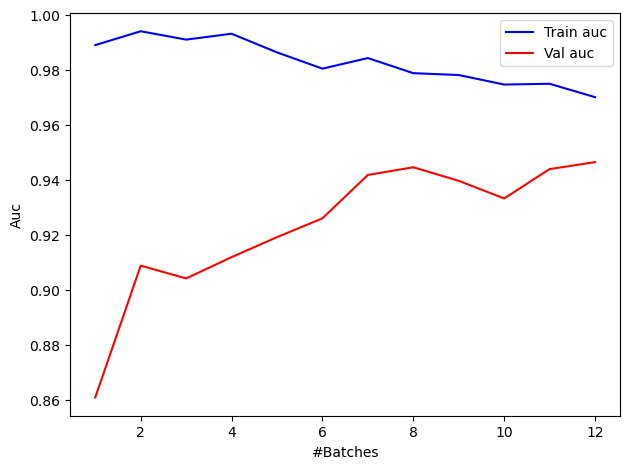

In [44]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

The learning curve looks great! The validation accuracy improves as more examples are seen.

Since training `SGDClassifier` may take long, you can save your trained classifier to disk periodically:

In [46]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./datasets/test.csv')
print('test auc: %.3f' % roc_auc_score(df_test['sentiment'], \
            clf.predict_proba(hashvec.transform(df_test['review']))[:,1]))

test auc: 0.930


Now you have the all the supporting knowledge for the competition. Happy coding and good luck!

## Precautions

### Scoring

The evaluation metric is AUC. The ranking shown on the leaderboard before the end of the competition reflects only the AUC performance over **part of** `test.csv`. However, this is **not** how we evaluate your final scores. After the competition, we calculate AUC over the entire `test.csv` and report the final ranking thereby.

There will be two baseline results, namely, `Benchmark-60` and `Benchmark-80`. You have to outperform `Benchmark-60` to get 60 points, and `Benchmark-80` to get 80. Meanwhile, the higher AUC you achieve, the higher the final score you will get.

### Rules

What you can do:

- Use untaught APIs: you can use any machine learning tools you like as well as models/techniques that are not taught in the class.

What you **can't** do:

- Create specific deterministic rules that make predictions. For example, you can not hard code decision rules in your submission, but you can use a `DecisionTreeClassifier` that learns rules from data.
- Train models using representation learning based on neural networks. For example, you can not use word2vec/RNN or any other deep-learning techniques in this competition.
Violation of any prohibited rule will be considered as cheating and results in **0 final score**.

### Honor code

In addition to the behaviors outlined by the official competition rules, "cheating" encompasses any attempt to gain an edge in accuracy by using information that is outside of the provided dataset, or an attempt to use the provided information in a way that is not intended, or attempt to copy code from other teams. Examples of cheating include (but are not limited to):

- Use datasets and references beyond those made available by the competition.
- Abuse the competition infrastructure to gain an edge.
- Copy code from other teams.

Your team will get 0 score in this competition once being found out cheating.

### Important Dates

- 2022/10/12 (Thur) - competition starts
- 2022/10/27 (Fri) 8:00 - competition ends, final score announcement
- 2022/10/29 (Sun) 23:59 - report submission (to eeclass)
- 2022/11/2 (Thur) - competition 1 show off


### Report

After the competition, **each team has to hand in a report** in Jupyter notebook format via the eeclass system. Your report should include:

- Student ID, name of each team member.
- How did you preprocess data, e.g. cleaning, feature engineering, etc?
- How did you build the classifier, e.g. model, training algorithm, special techniques, etc?
- Conclusions, including interesting findings, pitfalls, takeaway lessons, etc.

The file name of your report must be: `DL_comp1_{Your Team number}_report.ipynb`.